In [122]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from cnn_utils import load_imagesPath_ages_sex
from sklearn.model_selection import train_test_split
import random
import cv2
from sklearn.decomposition import PCA
from operator import itemgetter
from inception_utilits import conv2d_bn, stem_block, inception_a_block, inception_b_block, inception_c_block, reduction_a_block, reduction_b_block



In [2]:
train_truth = pd.read_csv('./data.nosync/train/train.csv')
validation_truth = pd.read_csv('./data.nosync/validation/Validation Dataset.csv')
test_truth = pd.read_excel('./data.nosync/test/Bone age ground truth.xlsx')

In [3]:
path_data_dir = 'data.nosync'
full_path = os.path.join(os.getcwd(), path_data_dir)
X_train, age_train, sex_train, X_validation, age_validation, sex_validation, X_test, age_test, sex_test = load_imagesPath_ages_sex(full_path, train_truth, validation_truth, test_truth, 100)

prendo le image_names da  /Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/train/images
prendo le image_names da  /Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/validation/images
prendo le image_names da  /Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/test/images


In [5]:
print("X shape:", len(X_test))
print("X train shape:", len(X_train))
print("X test shape:", len(X_test))

X shape: 100
X train shape: 100
X test shape: 100


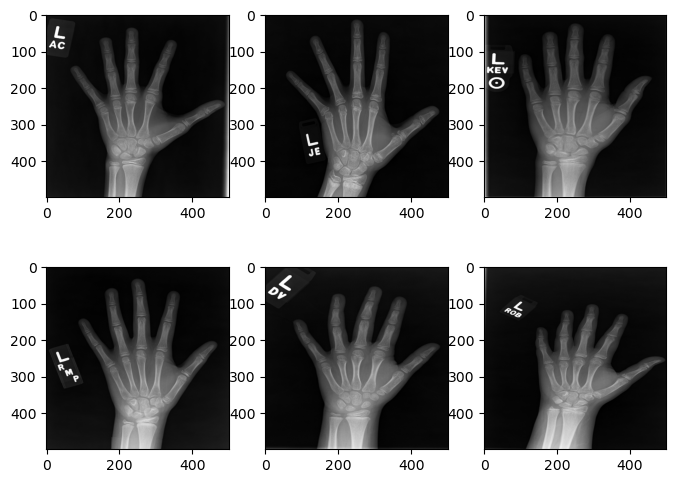

In [100]:
IMG_SHAPE = (500, 500, 3)


def show_image(x):
    plt.imshow(x)

def load_image(img_path, IMG_SHAPE):
    num_row = IMG_SHAPE[1]
    num_col = IMG_SHAPE[0]

    if isinstance(img_path, bytes):
        img_path = img_path.decode()

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = np.array(cv2.resize(img, (num_row, num_col)), dtype='float32')

    return img

def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = random.randint(0, len(age_train))
    show_image(normalize_img(load_image(X_train[idx], IMG_SHAPE)))
    #plt.title(labels[Y_train[idx]])

Try pca to see if it possible to understand if the images are rotated. Use 2 components, I expect them to be x1(diretricce polso-punta indice) and x2 (orizzontale). Se così fosse, usando immagini dritte, quando ne vedo una che non so se sia dritta o meno potrei verificarlo e ruotarla in caso. Uso un dataset selezionato con immagini dritte. 

In [101]:
rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)

(500, 500, 3)
Blue Channel : 0.7341887950897217
Green Channel: 0.7341887950897217
Red Channel  : 0.7341887950897217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


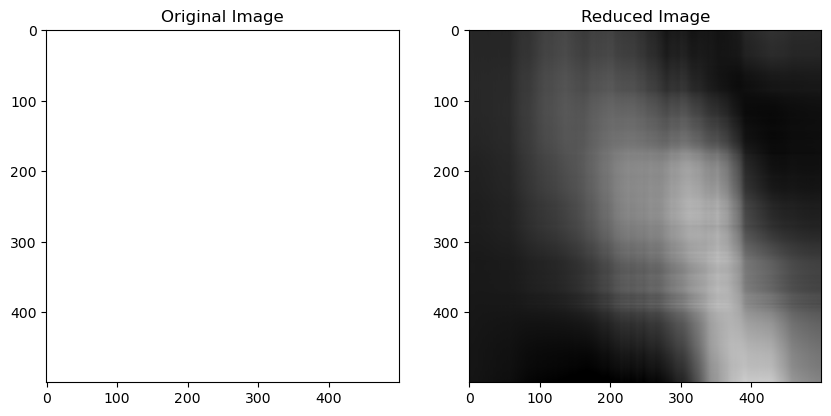

In [120]:

# idx = random.sample(range(0, len(age_train)), n_samples) 
# random_sample = list(itemgetter(*idx)(X_train))

rotated_img = '/Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/train/images/1489.png'
img =  load_image(rotated_img, IMG_SHAPE)
print(img.shape)
blue,green,red = (cv2.split(img))
df_blue = blue/255
df_green = green/255
df_red = red/255

pca_b = PCA(n_components=2)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=2)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=2)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)

img_reduced = (cv2.merge((b_arr, g_arr, r_arr)))

fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

# selected_subset = X_train[0:20] # to be defined
# data = []
# for img_path in X_train:
#     img = load_image(img_path, IMG_SHAPE)
#     blue,green,red = cv2.split(img)
#     df_blue = blue/255
#     df_green = green/255
#     df_red = red/255
# df_blue.shape
# pca = PCA(2) # we need 2 principal components.
# converted_data = pca.fit_transform(data)
 
# converted_data.shape

### Create the dataset

In [81]:
def create_dataset(file_names, ages, input_size, batch_size, shuffle, cache_file=None):

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, ages))

    # Map the load_image function
    py_func = lambda file_name, ages: (tf.numpy_function(load_image, [file_name, input_size], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # # Map the preprocess_data function
    # py_func = lambda file_name, label: (tf.numpy_function(preprocess_data, [file_name, data_dir],
    #                                                          tf.float32), label)
    # dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())


    # # # Duplicate data for the autoencoder (input = output)
    # # py_funct = lambda img: (img, img)
    # # dataset = dataset.map(py_funct)

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [82]:
batch_size = 32
train_dataset = create_dataset(file_names = X_train, 
                    ages = age_train, 
                    input_size = IMG_SHAPE,
                    batch_size = batch_size, 
                    shuffle = False )  

validation_dataset = create_dataset(file_names = X_validation, 
                    ages = age_validation, 
                    input_size = IMG_SHAPE,
                    batch_size = batch_size, 
                    shuffle = False ) 

test_dataset = create_dataset(file_names = X_test, 
                    ages = age_test, 
                    input_size = IMG_SHAPE,
                    batch_size = batch_size, 
                    shuffle = False )    

train_steps = int(np.ceil(len(X_train) / batch_size))
validation_step = int(np.ceil(len(X_validation) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))             

In [ ]:

def Inceptionv4(input_shape):
    """
    Implementation of the Inception-v4 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    ### START CODE HERE ###

    # Define the input as a tensor with shape input_shape (1 line)
    X_input = Input(input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    X = inception_a_block(X, 'a1')
    X = inception_a_block(X, 'a2')
    X = inception_a_block(X, 'a3')
    X = inception_a_block(X, 'a4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = inception_b_block(X, 'b1')
    X = inception_b_block(X, 'b2')
    X = inception_b_block(X, 'b3')
    X = inception_b_block(X, 'b4')
    X = inception_b_block(X, 'b5')
    X = inception_b_block(X, 'b6')
    X = inception_b_block(X, 'b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = inception_c_block(X, 'c1')
    X = inception_c_block(X, 'c2')
    X = inception_c_block(X, 'c3')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
    X = Flatten()(X)

    # Dropout
    X = Dropout(rate = 0.2)(X)

    # Output layer
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    ### END CODE HERE ###
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    return model